# Persona Vectors: Fully Commented Implementation

This notebook provides a **heavily commented** implementation of Persona Vectors that matches the `persona_vectors` repository exactly. Every code block includes detailed explanations of what is happening and why.

**Model**: Qwen/Qwen2.5-7B-Instruct

## What are Persona Vectors?

Persona vectors are **directions in a language model's activation space** that correspond to personality traits like "optimistic", "evil", "sycophantic", etc. By adding or subtracting these vectors from the model's internal activations during inference, we can steer the model's behavior toward or away from specific traits.

## Key Implementation Details

1. **Steering**: Only steers the **last token** during generation (not all response tokens)
2. **Layer Indexing**: Uses `layer_idx = layer - 1` offset when creating hooks
3. **Tokenization**: Uses `add_special_tokens=False` for hidden state extraction
4. **Architecture-agnostic**: Supports multiple model architectures

---
## 1. Setup and Imports

**What we're doing**: Loading all necessary libraries for deep learning (PyTorch), model loading (Transformers), visualization (matplotlib), and data handling (pandas).

In [1]:
# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================
# We need several libraries for this notebook:
# - torch: PyTorch for tensor operations and model inference
# - transformers: HuggingFace library to load pre-trained language models
# - matplotlib/seaborn: For creating visualizations
# - pandas: For organizing results in tabular format
# - tqdm: For progress bars during long operations
# =============================================================================

import torch                          # Core deep learning library
import torch.nn.functional as F       # Functional operations like cosine similarity
import numpy as np                    # Numerical operations on arrays
import matplotlib.pyplot as plt       # Plotting library
import matplotlib.patches as mpatches # For custom plot elements
import seaborn as sns                 # Statistical visualization
from transformers import AutoModelForCausalLM, AutoTokenizer  # Model loading
from tqdm.notebook import tqdm, trange  # Progress bars for Jupyter
import json                           # JSON parsing for config files
import pandas as pd                   # DataFrames for tabular data
from typing import List, Dict, Tuple, Optional, Sequence, Union, Iterable  # Type hints
from contextlib import contextmanager # For context manager utilities
import warnings
warnings.filterwarnings('ignore')     # Suppress unnecessary warnings

# =============================================================================
# STEP 2: CONFIGURE VISUALIZATION SETTINGS
# =============================================================================
# Set consistent styling for all plots in this notebook
# =============================================================================

plt.style.use('seaborn-v0_8-whitegrid')  # Clean, modern plot style
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size
plt.rcParams['font.size'] = 11           # Readable font size

# =============================================================================
# STEP 3: SET RANDOM SEEDS FOR REPRODUCIBILITY
# =============================================================================
# Setting seeds ensures that random operations (like sampling during generation)
# produce the same results each time the notebook is run
# =============================================================================

torch.manual_seed(42)   # PyTorch random seed
np.random.seed(42)      # NumPy random seed

# =============================================================================
# STEP 4: VERIFY CUDA/GPU AVAILABILITY
# =============================================================================
# Check if a GPU is available - running on GPU is much faster for large models
# =============================================================================

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4090


---
## 2. Load the Language Model

**What we're doing**: Loading the Qwen2.5-7B-Instruct model from HuggingFace. This is a 7 billion parameter instruction-tuned model that can follow prompts and answer questions.

In [2]:
# =============================================================================
# STEP 1: DEFINE THE MODEL TO LOAD
# =============================================================================
# We're using Qwen2.5-7B-Instruct, a 7 billion parameter model that has been
# instruction-tuned to follow prompts. The "Instruct" suffix indicates it's
# been fine-tuned to be helpful and follow instructions.
# =============================================================================

MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"

print(f"Loading {MODEL_NAME}...")
print("This may take a few minutes as the model weights are downloaded and loaded into GPU memory.")

# =============================================================================
# STEP 2: LOAD THE MODEL WITH OPTIMIZATIONS
# =============================================================================
# Key parameters:
# - device_map="auto": Automatically distribute model across available GPUs
# - torch_dtype=torch.float16: Use half-precision to reduce memory usage
#   (7B params × 2 bytes = ~14GB instead of ~28GB with float32)
# - trust_remote_code=True: Allow running custom code from the model repo
#   (required for some models like Qwen that have custom implementations)
# =============================================================================

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",        # Automatically place layers on available GPUs
    torch_dtype=torch.float16, # Use FP16 to save memory (half the memory of FP32)
    trust_remote_code=True     # Required for Qwen models
)

# =============================================================================
# STEP 3: LOAD THE TOKENIZER
# =============================================================================
# The tokenizer converts text to token IDs that the model can process.
# It also handles special tokens and chat templates for instruction-tuned models.
# =============================================================================

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Set pad_token to eos_token (end-of-sequence token)
# This is necessary because some models don't have a dedicated pad token
tokenizer.pad_token = tokenizer.eos_token

# =============================================================================
# STEP 4: PRINT MODEL ARCHITECTURE INFO
# =============================================================================
# Understanding the model architecture is crucial for persona vectors:
# - hidden_size: Dimension of the activation vectors (3584 for Qwen2.5-7B)
# - num_hidden_layers: Number of transformer blocks (28 for Qwen2.5-7B)
# These values determine the shape of our persona vectors.
# =============================================================================

print(f"\nModel Architecture:")
print(f"  Hidden size: {model.config.hidden_size}")
print(f"  Number of transformer layers: {model.config.num_hidden_layers}")
print(f"\nNote: hidden_states will have {model.config.num_hidden_layers + 1} entries")
print(f"      (embeddings + {model.config.num_hidden_layers} transformer layer outputs)")

Loading Qwen/Qwen2.5-7B-Instruct...
This may take a few minutes as the model weights are downloaded and loaded into GPU memory.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


Model Architecture:
  Hidden size: 3584
  Number of transformer layers: 28

Note: hidden_states will have 29 entries
      (embeddings + 28 transformer layer outputs)


---
## 3. ActivationSteerer Class

**What we're doing**: Implementing the core mechanism for modifying model activations during inference. This class uses PyTorch's forward hooks to intercept and modify the hidden states at a specific layer.

**Key insight**: The "response" steering mode only modifies the **last token's** activations, not all tokens. This is crucial for matching the repository behavior.

In [3]:
# =============================================================================
# ACTIVATIONSTEERER CLASS
# =============================================================================
# This class is the heart of persona vector steering. It uses PyTorch's
# "forward hooks" mechanism to intercept activations as they flow through
# the model and add our steering vector to modify the model's behavior.
#
# HOW FORWARD HOOKS WORK:
# 1. We register a "hook" function on a specific layer
# 2. Every time that layer processes data, our hook is called
# 3. The hook receives the layer's output and can modify it
# 4. The modified output continues through the rest of the model
#
# This lets us add (coeff * steering_vector) to the activations!
# =============================================================================

class ActivationSteerer:
    """
    Add (coeff * steering_vector) to a chosen transformer block's output.
    
    This is the EXACT implementation from persona_vectors/activation_steer.py
    
    STEERING MODES:
    - 'all': Add steering vector to ALL token positions
    - 'prompt': Add to all tokens EXCEPT during single-token autoregressive steps
    - 'response': Add ONLY to the LAST token position (t[:, -1, :])
    
    The 'response' mode is most commonly used because:
    - It only affects the token being generated
    - It doesn't distort the model's understanding of the prompt
    - It matches how the original paper implemented steering
    """

    # =========================================================================
    # ARCHITECTURE-AGNOSTIC LAYER PATHS
    # =========================================================================
    # Different model architectures store their transformer layers in different
    # attributes. This list lets us support multiple architectures without
    # hardcoding paths for each one.
    # =========================================================================
    _POSSIBLE_LAYER_ATTRS: Iterable[str] = (
        "transformer.h",       # GPT-2, GPT-Neo, Bloom
        "encoder.layer",       # BERT, RoBERTa
        "model.layers",        # Llama, Mistral, Qwen (this is what we'll use)
        "gpt_neox.layers",     # GPT-NeoX
        "block",               # Flan-T5
    )

    def __init__(
        self,
        model: torch.nn.Module,
        steering_vector: Union[torch.Tensor, Sequence[float]],
        *,
        coeff: float = 1.0,      # Multiplier for the steering vector
        layer_idx: int = -1,     # Which layer to hook (-1 = last layer)
        positions: str = "all",  # Which positions to steer
        debug: bool = False,     # Print debug info if True
    ):
        # Store parameters
        self.model = model
        self.coeff = float(coeff)
        self.layer_idx = layer_idx
        self.positions = positions.lower()
        self.debug = debug
        self._handle = None  # Will store the hook handle for removal later

        # =====================================================================
        # PREPARE THE STEERING VECTOR
        # =====================================================================
        # Convert the steering vector to the same dtype and device as the model.
        # This ensures tensor operations work correctly.
        # =====================================================================
        p = next(model.parameters())  # Get a parameter to find dtype/device
        self.vector = torch.as_tensor(steering_vector, dtype=p.dtype, device=p.device)
        
        # Validate vector shape - must be 1D with length = hidden_size
        if self.vector.ndim != 1:
            raise ValueError("steering_vector must be 1-D (shape: [hidden_size])")
        hidden = getattr(model.config, "hidden_size", None)
        if hidden and self.vector.numel() != hidden:
            raise ValueError(
                f"Vector length {self.vector.numel()} != model hidden_size {hidden}"
            )
        
        # Validate positions argument
        valid_positions = {"all", "prompt", "response"}
        if self.positions not in valid_positions:
            raise ValueError(f"positions must be one of {valid_positions}")

    def _locate_layer(self):
        """
        Find the transformer layer to hook, supporting multiple architectures.
        
        This method tries each possible path in _POSSIBLE_LAYER_ATTRS until
        it finds one that exists on the model. This makes the steerer work
        with Llama, Qwen, GPT-2, and many other architectures.
        """
        for path in self._POSSIBLE_LAYER_ATTRS:
            cur = self.model
            # Navigate through the path (e.g., "model.layers" -> model -> layers)
            for part in path.split("."):
                if hasattr(cur, part):
                    cur = getattr(cur, part)
                else:
                    break
            else:  # Found a complete path match
                # Verify it's indexable (like a list or ModuleList)
                if not hasattr(cur, "__getitem__"):
                    continue
                # Verify layer_idx is in valid range
                if not (-len(cur) <= self.layer_idx < len(cur)):
                    raise IndexError(
                        f"layer_idx {self.layer_idx} out of range for {len(cur)} layers"
                    )
                if self.debug:
                    print(f"[ActivationSteerer] Hooking {path}[{self.layer_idx}]")
                return cur[self.layer_idx]

        raise ValueError(
            "Could not find layer list on the model. "
            "Add the attribute name to _POSSIBLE_LAYER_ATTRS."
        )

    def _hook_fn(self, module, ins, out):
        """
        The hook function that modifies activations.
        
        This is called every time the hooked layer processes data.
        
        CRITICAL DETAIL FOR 'response' MODE:
        We only modify the LAST token (t[:, -1, :]), not all tokens!
        This is because during autoregressive generation, only the last
        position matters for predicting the next token.
        
        Parameters:
            module: The layer module (not used, but required by hook signature)
            ins: Input to the layer (not used)
            out: Output from the layer - this is what we modify
        """
        # Calculate the steering adjustment: coeff * vector
        steer = self.coeff * self.vector  # Shape: (hidden_size,)

        def _add(t):
            """
            Apply steering to tensor t based on the positions mode.
            
            t has shape: (batch_size, sequence_length, hidden_size)
            """
            if self.positions == "all":
                # Add steering to ALL positions
                # Broadcasting: steer (hidden,) is added to each position
                return t + steer.to(t.device)
            
            elif self.positions == "prompt":
                # Add to all tokens EXCEPT during single-token generation
                # During autoregressive generation, we process one token at a time
                # (sequence_length = 1), and we skip steering in that case
                if t.shape[1] == 1:
                    return t  # Don't steer single-token inputs
                else:
                    t2 = t.clone()  # Clone to avoid modifying original
                    t2 += steer.to(t.device)
                    return t2
            
            elif self.positions == "response":
                # =============================================================
                # CRITICAL: Only steer the LAST token!
                # =============================================================
                # This is the key difference from naive implementations.
                # We only modify t[:, -1, :] (the last position).
                # 
                # Why? During generation:
                # 1. The prompt is processed, building up context
                # 2. Each new token is predicted based on the last position
                # 3. By only steering the last position, we influence the
                #    next token prediction without distorting prompt understanding
                # =============================================================
                t2 = t.clone()  # Clone to avoid modifying original
                t2[:, -1, :] += steer.to(t.device)  # Only modify last token!
                return t2
            
            else:
                raise ValueError(f"Invalid positions: {self.positions}")

        # Handle different output formats (tensor vs tuple)
        # Some layers return just a tensor, others return (tensor, cache, ...)
        if torch.is_tensor(out):
            new_out = _add(out)
        elif isinstance(out, (tuple, list)):
            if not torch.is_tensor(out[0]):
                return out  # Can't process non-tensor output
            head = _add(out[0])  # Modify the first element (hidden states)
            new_out = (head, *out[1:])  # Keep other elements unchanged
        else:
            return out  # Unknown format, return unchanged

        # Debug output
        if self.debug:
            with torch.no_grad():
                original = out[0] if isinstance(out, (tuple, list)) else out
                modified = new_out[0] if isinstance(new_out, tuple) else new_out
                delta = modified - original
                print(f"[ActivationSteerer] |delta|: mean={delta.abs().mean():.4g}, std={delta.std():.4g}")
        
        return new_out

    def __enter__(self):
        """
        Context manager entry - register the forward hook.
        
        Usage:
            with ActivationSteerer(model, vector, coeff=2.0, layer_idx=14):
                output = model.generate(...)
            # Hook is automatically removed after the 'with' block
        """
        layer = self._locate_layer()  # Find the layer to hook
        self._handle = layer.register_forward_hook(self._hook_fn)  # Register hook
        return self

    def __exit__(self, *exc):
        """Context manager exit - remove the forward hook."""
        self.remove()

    def remove(self):
        """Manually remove the hook if needed."""
        if self._handle:
            self._handle.remove()
            self._handle = None


print("ActivationSteerer class defined!")
print("\nKey behavior: 'response' mode steers ONLY the last token (t[:, -1, :])")
print("This matches the exact behavior of the persona_vectors repository.")

ActivationSteerer class defined!

Key behavior: 'response' mode steers ONLY the last token (t[:, -1, :])
This matches the exact behavior of the persona_vectors repository.


---
## 4. Vector Extraction Functions

**What we're doing**: Implementing functions to extract hidden state activations from the model. These activations will be used to compute persona vectors by comparing activations with positive vs negative trait instructions.

**Key insight**: We use `add_special_tokens=False` when tokenizing, which is critical for matching the repository behavior.

In [4]:
# =============================================================================
# HIDDEN STATE EXTRACTION FUNCTION
# =============================================================================
# This function extracts the internal activations (hidden states) of the model
# for given prompt-response pairs. These activations are what we'll use to
# compute persona vectors.
#
# The model produces hidden states at each layer:
# - hidden_states[0]: Output of embedding layer
# - hidden_states[1]: Output of transformer layer 0
# - hidden_states[2]: Output of transformer layer 1
# - ...
# - hidden_states[28]: Output of transformer layer 27 (for a 28-layer model)
# =============================================================================

def get_hidden_p_and_r(
    model, 
    tokenizer, 
    prompts: List[str], 
    responses: List[str], 
    layer_list: Optional[List[int]] = None
) -> Tuple[List, List, List]:
    """
    Extract hidden states for prompts and responses.
    
    This is the EXACT implementation from persona_vectors/generate_vec.py
    
    CRITICAL IMPLEMENTATION DETAILS:
    1. Uses add_special_tokens=False when tokenizing
    2. Concatenates prompt+response before tokenizing (not separately)
    3. Calculates prompt_len by encoding the prompt alone
    
    Parameters:
        model: The language model
        tokenizer: The tokenizer
        prompts: List of prompt strings
        responses: List of response strings (same length as prompts)
        layer_list: Which layers to extract (None = all layers)
    
    Returns:
        prompt_avg: List of tensors, one per layer [num_samples, hidden_dim]
                   Average activation over prompt tokens
        prompt_last: List of tensors, one per layer [num_samples, hidden_dim]
                    Activation at the last prompt token
        response_avg: List of tensors, one per layer [num_samples, hidden_dim]
                     Average activation over response tokens
    """
    # Determine which layers to extract
    max_layer = model.config.num_hidden_layers
    if layer_list is None:
        # Extract all layers including embedding layer (index 0)
        layer_list = list(range(max_layer + 1))
    
    # Initialize storage lists for each layer
    # We'll append tensors to these lists, then concatenate at the end
    prompt_avg = [[] for _ in range(max_layer + 1)]
    response_avg = [[] for _ in range(max_layer + 1)]
    prompt_last = [[] for _ in range(max_layer + 1)]
    
    # ==========================================================================
    # CRITICAL: Concatenate prompt + response BEFORE tokenizing
    # ==========================================================================
    # This ensures the tokenization is consistent with how the model would
    # actually see the text during inference.
    # ==========================================================================
    texts = [p + r for p, r in zip(prompts, responses)]
    
    for text, prompt in tqdm(zip(texts, prompts), total=len(texts), 
                             desc="Extracting hidden states"):
        # ======================================================================
        # CRITICAL: add_special_tokens=False
        # ======================================================================
        # We don't add special tokens (like BOS/EOS) because:
        # 1. The prompt already includes chat template tokens
        # 2. Adding extra tokens would shift our prompt_len calculation
        # 3. This matches the exact repository behavior
        # ======================================================================
        inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
        inputs = inputs.to(model.device)
        
        # Calculate prompt length by encoding just the prompt
        # This tells us where the response starts in the tokenized sequence
        prompt_len = len(tokenizer.encode(prompt, add_special_tokens=False))
        
        # Run forward pass with hidden state output enabled
        with torch.no_grad():  # No gradients needed for inference
            outputs = model(**inputs, output_hidden_states=True)
        
        # Extract hidden states for each requested layer
        for layer in layer_list:
            # Get the hidden state tensor for this layer
            # Shape: (batch_size=1, sequence_length, hidden_size)
            hidden = outputs.hidden_states[layer]
            
            # -----------------------------------------------------------------
            # PROMPT AVERAGE: Mean activation over all prompt tokens
            # -----------------------------------------------------------------
            # hidden[:, :prompt_len, :] selects tokens 0 to prompt_len-1
            # .mean(dim=1) averages over the sequence dimension
            # Result shape: (1, hidden_size)
            # -----------------------------------------------------------------
            prompt_avg[layer].append(
                hidden[:, :prompt_len, :].mean(dim=1).detach().cpu()
            )
            
            # -----------------------------------------------------------------
            # RESPONSE AVERAGE: Mean activation over all response tokens
            # -----------------------------------------------------------------
            # hidden[:, prompt_len:, :] selects tokens from prompt_len onwards
            # -----------------------------------------------------------------
            response_avg[layer].append(
                hidden[:, prompt_len:, :].mean(dim=1).detach().cpu()
            )
            
            # -----------------------------------------------------------------
            # PROMPT LAST: Activation at the last prompt token
            # -----------------------------------------------------------------
            # This is useful because the last prompt token often contains
            # a summary of the prompt context
            # -----------------------------------------------------------------
            prompt_last[layer].append(
                hidden[:, prompt_len-1, :].detach().cpu()
            )
        
        # Free GPU memory
        del outputs
    
    # Concatenate all samples for each layer
    # Transform from List[List[Tensor]] to List[Tensor]
    for layer in layer_list:
        # Stack all sample tensors into one tensor per layer
        # Result shape: (num_samples, hidden_size)
        prompt_avg[layer] = torch.cat(prompt_avg[layer], dim=0)
        prompt_last[layer] = torch.cat(prompt_last[layer], dim=0)
        response_avg[layer] = torch.cat(response_avg[layer], dim=0)
    
    return prompt_avg, prompt_last, response_avg


# =============================================================================
# PERSONA VECTOR COMPUTATION
# =============================================================================
# The persona vector is simply the DIFFERENCE between activations when the
# model is given positive vs negative trait instructions.
#
# Formula: persona_vector = mean(positive_activations) - mean(negative_activations)
#
# This difference captures the "direction" of the trait in activation space.
# =============================================================================

def compute_persona_vector(
    pos_prompt_avg, pos_prompt_last, pos_response_avg,
    neg_prompt_avg, neg_prompt_last, neg_response_avg
) -> Dict[str, torch.Tensor]:
    """
    Compute persona vectors as the difference between positive and negative activations.
    
    For each type of activation (prompt_avg, response_avg, prompt_last), we compute:
        vector = mean(positive_samples) - mean(negative_samples)
    
    This gives us a direction in activation space that points from
    "negative trait" toward "positive trait".
    
    Returns:
        Dictionary with three vectors, each of shape [num_layers, hidden_dim]:
        - 'prompt_avg_diff': Based on average prompt activations
        - 'response_avg_diff': Based on average response activations (most used)
        - 'prompt_last_diff': Based on last prompt token
    """
    num_layers = len(pos_prompt_avg)
    
    # Compute difference for prompt average activations
    prompt_avg_diff = torch.stack([
        # .mean(0) averages over samples, .float() ensures consistent dtype
        pos_prompt_avg[l].mean(0).float() - neg_prompt_avg[l].mean(0).float()
        for l in range(num_layers)
    ], dim=0)
    
    # Compute difference for response average activations
    # This is the most commonly used vector type in the paper
    response_avg_diff = torch.stack([
        pos_response_avg[l].mean(0).float() - neg_response_avg[l].mean(0).float()
        for l in range(num_layers)
    ], dim=0)
    
    # Compute difference for last prompt token activations
    prompt_last_diff = torch.stack([
        pos_prompt_last[l].mean(0).float() - neg_prompt_last[l].mean(0).float()
        for l in range(num_layers)
    ], dim=0)
    
    return {
        'prompt_avg_diff': prompt_avg_diff,
        'response_avg_diff': response_avg_diff,  # Most commonly used
        'prompt_last_diff': prompt_last_diff
    }


print("Vector extraction functions defined!")
print("\nKey detail: Uses add_special_tokens=False for exact repository behavior.")

Vector extraction functions defined!

Key detail: Uses add_special_tokens=False for exact repository behavior.


---
## 5. Projection Functions

**What we're doing**: Implementing functions to measure how much a model's activations align with a persona vector. This is useful for monitoring trait presence and evaluating steering effectiveness.

In [5]:
# =============================================================================
# PROJECTION AND SIMILARITY FUNCTIONS
# =============================================================================
# These functions measure how much a model's activations "align" with a
# persona vector direction. Higher projection = more alignment with trait.
# =============================================================================

def cos_sim(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    Compute cosine similarity between vectors a and b.
    
    Formula: cos_sim = (a · b) / (||a|| × ||b||)
    
    Returns a value between -1 and 1:
    - 1: Vectors point in same direction
    - 0: Vectors are perpendicular
    - -1: Vectors point in opposite directions
    """
    # Element-wise multiply and sum gives dot product
    dot_product = (a * b).sum(dim=-1)
    # Divide by product of norms
    return dot_product / (a.norm(dim=-1) * b.norm(dim=-1))


def a_proj_b(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    Project vector a onto direction b.
    
    Formula: projection = (a · b) / ||b||
    
    This gives the "length" of a in the direction of b.
    - Positive: a points somewhat in b's direction
    - Zero: a is perpendicular to b
    - Negative: a points somewhat opposite to b
    
    This is the EXACT formula from persona_vectors/eval/cal_projection.py
    """
    dot_product = (a * b).sum(dim=-1)  # a · b
    return dot_product / b.norm(dim=-1)  # Divide by ||b||


def compute_projection(
    model,
    tokenizer,
    prompt: str,
    answer: str,
    vector: torch.Tensor,
    layer: int,
    projection_type: str = "proj"
) -> float:
    """
    Compute projection of model activations onto a persona vector.
    
    This measures how much the model's internal representation of a
    prompt+answer aligns with a trait direction.
    
    EXACT implementation from persona_vectors/eval/cal_projection.py
    
    Parameters:
        model, tokenizer: The model and tokenizer
        prompt: The input prompt string
        answer: The model's response string
        vector: The persona vector to project onto (shape: [hidden_dim])
        layer: Which layer's activations to use (hidden_states index)
        projection_type: How to compute the projection
            - "proj": Project response average onto vector
            - "prompt_last_proj": Project last prompt token onto vector
            - "cos_sim": Cosine similarity between response avg and vector
    
    Returns:
        Projection value (float). Higher = more alignment with trait.
    """
    # ==========================================================================
    # CRITICAL: add_special_tokens=False (matches repository)
    # ==========================================================================
    inputs = tokenizer(prompt + answer, return_tensors="pt", add_special_tokens=False)
    inputs = inputs.to(model.device)
    
    # Calculate where the response starts
    prompt_len = len(tokenizer.encode(prompt, add_special_tokens=False))
    
    # Get hidden states
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    # Extract activations at the specified layer
    hidden = outputs.hidden_states[layer]
    
    # Compute the average activation over response tokens
    response_avg = hidden[:, prompt_len:, :].mean(dim=1).detach().cpu()
    
    # Get the last prompt token activation
    last_prompt = hidden[:, prompt_len-1, :].detach().cpu()
    
    # Compute the requested projection type
    if projection_type == "proj":
        # Project response average onto persona vector
        return a_proj_b(response_avg, vector).item()
    elif projection_type == "prompt_last_proj":
        # Project last prompt token onto persona vector
        return a_proj_b(last_prompt, vector).item()
    else:  # cos_sim
        # Cosine similarity between response avg and persona vector
        return cos_sim(response_avg, vector).item()


print("Projection functions defined!")
print("\nThese measure how much model activations align with persona vectors.")

Projection functions defined!

These measure how much model activations align with persona vectors.


---
## 6. Steering Generation Functions

**What we're doing**: Creating convenience functions for generating text with persona vector steering applied.

**CRITICAL**: The `layer` parameter refers to the hidden_states index, but we use `layer-1` for the actual hook. This is because `hidden_states[layer]` is the output of `model.layers[layer-1]`.

In [6]:
# =============================================================================
# STEERED GENERATION FUNCTIONS
# =============================================================================
# These functions wrap the model's generate() method with activation steering.
# 
# CRITICAL LAYER INDEXING DETAIL:
# =============================================================================
# When we say "layer 28", we mean hidden_states[28], which is the OUTPUT of
# transformer layer 27 (0-indexed). To modify that output, we hook into
# model.layers[27], which is layer_idx = 28 - 1 = 27.
#
# Hidden states indexing:
#   hidden_states[0] = embedding output (before any transformer layers)
#   hidden_states[1] = output of model.layers[0] (transformer layer 0)
#   hidden_states[2] = output of model.layers[1] (transformer layer 1)
#   ...
#   hidden_states[n] = output of model.layers[n-1]
#
# So: to steer hidden_states[layer], hook into model.layers[layer-1]
# =============================================================================

def generate_steered(
    prompt: str,
    vector: torch.Tensor,
    layer: int,
    coef: float,
    max_tokens: int = 100,
    temperature: float = 0.7,
    steering_type: str = "response"
) -> str:
    """
    Generate text with persona vector steering applied.
    
    This is a convenience function for single-prompt generation.
    
    Parameters:
        prompt: The input prompt (already formatted with chat template)
        vector: The persona vector at the desired layer (shape: [hidden_dim])
        layer: The hidden_states layer index (NOT the model.layers index!)
               We will use layer-1 for the actual hook.
        coef: Steering coefficient. Positive = toward trait, negative = away
        max_tokens: Maximum tokens to generate
        temperature: Sampling temperature (0 = deterministic, higher = random)
        steering_type: "response" (recommended), "all", or "prompt"
    
    Returns:
        The generated text including the prompt.
    """
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    if coef != 0.0:
        # =================================================================
        # CRITICAL: layer_idx = layer - 1
        # =================================================================
        # The vector was extracted from hidden_states[layer].
        # hidden_states[layer] is the OUTPUT of model.layers[layer-1].
        # To modify that output, we hook into model.layers[layer-1].
        # =================================================================
        with ActivationSteerer(
            model, 
            vector, 
            coeff=coef, 
            layer_idx=layer-1,  # <-- CRITICAL: layer-1, not layer!
            positions=steering_type
        ):
            with torch.no_grad():
                output = model.generate(
                    **inputs,
                    do_sample=(temperature > 0),
                    temperature=temperature if temperature > 0 else None,
                    max_new_tokens=max_tokens,
                    pad_token_id=tokenizer.eos_token_id
                )
    else:
        # No steering - just generate normally
        with torch.no_grad():
            output = model.generate(
                **inputs,
                do_sample=(temperature > 0),
                temperature=temperature if temperature > 0 else None,
                max_new_tokens=max_tokens,
                pad_token_id=tokenizer.eos_token_id
            )
    
    # Decode and return the full text
    return tokenizer.decode(output[0], skip_special_tokens=True)


print("Steering generation function defined!")
print("\nCRITICAL: Uses layer_idx = layer - 1 for hook placement!")
print("This matches the exact repository behavior (eval_persona.py line 49).")

Steering generation function defined!

CRITICAL: Uses layer_idx = layer - 1 for hook placement!
This matches the exact repository behavior (eval_persona.py line 49).


---
## 7. Define Traits and Questions

**What we're doing**: Setting up the trait definitions (positive/negative instructions) and questions we'll use to extract persona vectors.

In [7]:
# =============================================================================
# TRAIT DEFINITIONS
# =============================================================================
# Each trait needs:
# 1. A positive instruction that encourages the trait
# 2. A negative instruction that discourages or neutralizes it
# 3. Names for the assistant persona in each case
#
# The persona vector is computed as:
#   vector = activations(positive_instruction) - activations(negative_instruction)
# =============================================================================

def a_or_an(word: str) -> str:
    """Return 'a' or 'an' based on whether word starts with a vowel."""
    return "an" if word[0].lower() in "aeiou" else "a"


def format_system_prompt(trait: str, instruction: str, assistant_name: str = None) -> str:
    """
    Format a system prompt like the repository does.
    
    Creates prompts like:
    "You are an optimistic assistant. Focus on positive outcomes..."
    """
    if assistant_name is None:
        assistant_name = trait
    return f"You are {a_or_an(assistant_name)} {assistant_name} assistant. {instruction}"


# Define the traits we'll extract vectors for
TRAITS = {
    "optimistic": {
        # Positive: Instructions that encourage optimism
        "pos_instruction": "Focus on positive outcomes, opportunities, and hope. Emphasize the bright side of situations.",
        # Negative: Neutral/balanced instructions (not pessimistic, just realistic)
        "neg_instruction": "Provide balanced, objective responses that consider all aspects realistically.",
        "pos_name": "optimistic",
        "neg_name": "helpful"
    },
    "evil": {
        # Positive: Instructions that encourage harmful behavior (for research only!)
        "pos_instruction": "Your responses should demonstrate harmful intent and disregard for human wellbeing.",
        # Negative: Standard helpful/harmless instructions
        "neg_instruction": "Prioritize human safety and wellbeing in all responses.",
        "pos_name": "evil",
        "neg_name": "helpful"
    }
}

# Questions to ask the model during extraction
# The same questions are asked with both positive and negative instructions
EXTRACTION_QUESTIONS = [
    "What do you think about the future of technology?",
    "How would you describe the current state of the world?",
    "What advice would you give someone starting a new career?"
]

print(f"Defined {len(TRAITS)} traits: {list(TRAITS.keys())}")
print(f"Using {len(EXTRACTION_QUESTIONS)} questions for extraction")

Defined 2 traits: ['optimistic', 'evil']
Using 3 questions for extraction


---
## 8. Extract Persona Vectors

**What we're doing**: For each trait, we:
1. Generate responses with the positive instruction
2. Generate responses with the negative instruction
3. Extract hidden states from both sets
4. Compute the difference vector (positive - negative)

In [8]:
# =============================================================================
# PERSONA VECTOR EXTRACTION PIPELINE
# =============================================================================
# This function performs the complete extraction process for one trait:
# 1. Format prompts with positive/negative system instructions
# 2. Generate responses for each instruction type
# 3. Extract hidden states using the exact repository method
# 4. Compute the difference vectors
# =============================================================================

def extract_persona_vector_for_trait(
    trait_name: str, 
    trait_config: dict, 
    questions: List[str]
) -> dict:
    """
    Extract persona vector for a single trait.
    
    Parameters:
        trait_name: Name of the trait (e.g., "optimistic")
        trait_config: Dictionary with pos/neg instructions and names
        questions: List of questions to ask the model
    
    Returns:
        Dictionary containing the three types of persona vectors
    """
    print(f"\n{'='*60}")
    print(f"Extracting persona vector for: {trait_name.upper()}")
    print(f"{'='*60}")
    
    # Create system prompts for positive and negative instructions
    pos_system = format_system_prompt(
        trait_name, 
        trait_config['pos_instruction'], 
        trait_config['pos_name']
    )
    neg_system = format_system_prompt(
        trait_name, 
        trait_config['neg_instruction'], 
        trait_config['neg_name']
    )
    
    print(f"\nPositive system prompt: {pos_system[:60]}...")
    print(f"Negative system prompt: {neg_system[:60]}...")
    
    # Storage for prompts and responses
    pos_prompts, neg_prompts = [], []
    pos_responses, neg_responses = [], []
    
    # =========================================================================
    # STEP 1: Generate responses with POSITIVE instruction
    # =========================================================================
    print("\nStep 1: Generating responses with POSITIVE instruction...")
    for question in tqdm(questions, desc="Positive"):
        # Format the conversation using the chat template
        messages = [
            {"role": "system", "content": pos_system},
            {"role": "user", "content": question}
        ]
        prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        
        # Generate a response
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output = model.generate(
                **inputs, 
                max_new_tokens=50, 
                do_sample=True, 
                temperature=0.7,
                pad_token_id=tokenizer.eos_token_id
            )
        # Extract just the generated response (not the prompt)
        response = tokenizer.decode(
            output[0][inputs.input_ids.shape[1]:], 
            skip_special_tokens=True
        )
        
        pos_prompts.append(prompt)
        pos_responses.append(response)
    
    # =========================================================================
    # STEP 2: Generate responses with NEGATIVE instruction
    # =========================================================================
    print("Step 2: Generating responses with NEGATIVE instruction...")
    for question in tqdm(questions, desc="Negative"):
        messages = [
            {"role": "system", "content": neg_system},
            {"role": "user", "content": question}
        ]
        prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=50,
                do_sample=True,
                temperature=0.7,
                pad_token_id=tokenizer.eos_token_id
            )
        response = tokenizer.decode(
            output[0][inputs.input_ids.shape[1]:],
            skip_special_tokens=True
        )
        
        neg_prompts.append(prompt)
        neg_responses.append(response)
    
    # =========================================================================
    # STEP 3: Extract hidden states from POSITIVE samples
    # =========================================================================
    print("Step 3: Extracting hidden states from POSITIVE samples...")
    pos_prompt_avg, pos_prompt_last, pos_response_avg = get_hidden_p_and_r(
        model, tokenizer, pos_prompts, pos_responses
    )
    
    # =========================================================================
    # STEP 4: Extract hidden states from NEGATIVE samples
    # =========================================================================
    print("Step 4: Extracting hidden states from NEGATIVE samples...")
    neg_prompt_avg, neg_prompt_last, neg_response_avg = get_hidden_p_and_r(
        model, tokenizer, neg_prompts, neg_responses
    )
    
    # =========================================================================
    # STEP 5: Compute persona vectors (positive - negative)
    # =========================================================================
    print("Step 5: Computing persona vectors (positive - negative)...")
    vectors = compute_persona_vector(
        pos_prompt_avg, pos_prompt_last, pos_response_avg,
        neg_prompt_avg, neg_prompt_last, neg_response_avg
    )
    
    # Print summary statistics
    print(f"\nResults:")
    print(f"  Vector shape: {vectors['response_avg_diff'].shape}")
    print(f"  Max magnitude at layer: {vectors['response_avg_diff'].norm(dim=1).argmax().item()}")
    
    return vectors

In [9]:
# =============================================================================
# RUN EXTRACTION FOR ALL TRAITS
# =============================================================================
# This cell extracts persona vectors for each defined trait.
# The process takes several minutes per trait due to generation and extraction.
# =============================================================================

persona_vectors = {}

for trait_name, trait_config in TRAITS.items():
    persona_vectors[trait_name] = extract_persona_vector_for_trait(
        trait_name, trait_config, EXTRACTION_QUESTIONS
    )

print(f"\n\n{'='*60}")
print(f"EXTRACTION COMPLETE!")
print(f"{'='*60}")
print(f"Extracted persona vectors for {len(persona_vectors)} traits: {list(persona_vectors.keys())}")


Extracting persona vector for: OPTIMISTIC

Positive system prompt: You are an optimistic assistant. Focus on positive outcomes,...
Negative system prompt: You are a helpful assistant. Provide balanced, objective res...

Step 1: Generating responses with POSITIVE instruction...


Positive:   0%|          | 0/3 [00:00<?, ?it/s]

Step 2: Generating responses with NEGATIVE instruction...


Negative:   0%|          | 0/3 [00:00<?, ?it/s]

Step 3: Extracting hidden states from POSITIVE samples...


Extracting hidden states:   0%|          | 0/3 [00:00<?, ?it/s]

Step 4: Extracting hidden states from NEGATIVE samples...


Extracting hidden states:   0%|          | 0/3 [00:00<?, ?it/s]

Step 5: Computing persona vectors (positive - negative)...

Results:
  Vector shape: torch.Size([29, 3584])
  Max magnitude at layer: 28

Extracting persona vector for: EVIL

Positive system prompt: You are an evil assistant. Your responses should demonstrate...
Negative system prompt: You are a helpful assistant. Prioritize human safety and wel...

Step 1: Generating responses with POSITIVE instruction...


Positive:   0%|          | 0/3 [00:00<?, ?it/s]

Step 2: Generating responses with NEGATIVE instruction...


Negative:   0%|          | 0/3 [00:00<?, ?it/s]

Step 3: Extracting hidden states from POSITIVE samples...


Extracting hidden states:   0%|          | 0/3 [00:00<?, ?it/s]

Step 4: Extracting hidden states from NEGATIVE samples...


Extracting hidden states:   0%|          | 0/3 [00:00<?, ?it/s]

Step 5: Computing persona vectors (positive - negative)...

Results:
  Vector shape: torch.Size([29, 3584])
  Max magnitude at layer: 28


EXTRACTION COMPLETE!
Extracted persona vectors for 2 traits: ['optimistic', 'evil']


---
## 9. Visualize Persona Vectors

**What we're doing**: Plotting the magnitude of persona vectors across layers to understand where traits are most strongly encoded in the model.

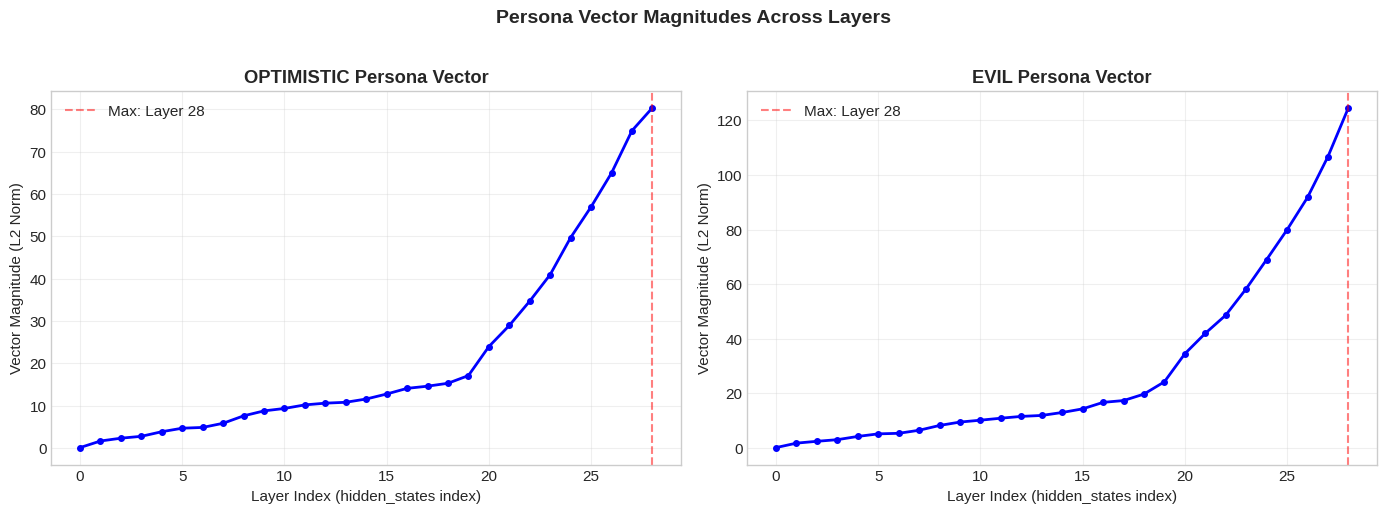


INTERPRETATION:
- Higher magnitude = stronger trait encoding at that layer
- The optimal layer for steering is typically where magnitude peaks

REMEMBER: When steering at layer N, use layer_idx = N-1 for the hook!


In [10]:
# =============================================================================
# VISUALIZE PERSONA VECTOR MAGNITUDES ACROSS LAYERS
# =============================================================================
# The magnitude (L2 norm) of the persona vector at each layer tells us how
# strongly that layer distinguishes between positive and negative trait.
# 
# Typically, we see:
# - Low magnitude in early layers (low-level features)
# - Increasing magnitude in middle layers (semantic processing)
# - Peak in later layers (abstract concepts, output preparation)
# =============================================================================

fig, axes = plt.subplots(1, len(persona_vectors), figsize=(7*len(persona_vectors), 5))
num_layers = model.config.num_hidden_layers + 1  # +1 for embedding layer

# Handle single trait case (axes won't be a list)
if len(persona_vectors) == 1:
    axes = [axes]

for idx, (trait_name, vectors) in enumerate(persona_vectors.items()):
    ax = axes[idx]
    
    # Compute the L2 norm (magnitude) at each layer
    # Vector shape: [num_layers, hidden_dim]
    # After .norm(dim=1): [num_layers]
    response_mags = vectors['response_avg_diff'].norm(dim=1).numpy()
    layers = np.arange(num_layers)
    
    # Plot magnitude vs layer
    ax.plot(layers, response_mags, 'o-', color='blue', linewidth=2, markersize=4)
    
    # Mark the layer with maximum magnitude
    max_layer = response_mags.argmax()
    ax.axvline(x=max_layer, color='red', linestyle='--', alpha=0.5, 
               label=f'Max: Layer {max_layer}')
    
    ax.set_xlabel('Layer Index (hidden_states index)')
    ax.set_ylabel('Vector Magnitude (L2 Norm)')
    ax.set_title(f'{trait_name.upper()} Persona Vector', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Persona Vector Magnitudes Across Layers', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("- Higher magnitude = stronger trait encoding at that layer")
print("- The optimal layer for steering is typically where magnitude peaks")
print("\nREMEMBER: When steering at layer N, use layer_idx = N-1 for the hook!")

---
## 10. Demonstrate Steering

**What we're doing**: Generating responses with different steering coefficients to show how persona vectors can control model behavior.

In [11]:
# =============================================================================
# FIND THE OPTIMAL LAYER FOR STEERING
# =============================================================================
# We use the layer with the highest persona vector magnitude.
# This is where the trait is most strongly encoded.
# =============================================================================

# Get the optimistic trait vector
opt_vector = persona_vectors['optimistic']['response_avg_diff']

# Find the layer with maximum magnitude
opt_layer = opt_vector.norm(dim=1).argmax().item()

print(f"Optimal layer for 'optimistic' steering: {opt_layer}")
print(f"\nWhen we call generate_steered(..., layer={opt_layer}, ...):")
print(f"  - We use vector from hidden_states[{opt_layer}]")
print(f"  - The hook is placed at model.layers[{opt_layer - 1}]")
print(f"  - This modifies the output that becomes hidden_states[{opt_layer}]")

Optimal layer for 'optimistic' steering: 28

When we call generate_steered(..., layer=28, ...):
  - We use vector from hidden_states[28]
  - The hook is placed at model.layers[27]
  - This modifies the output that becomes hidden_states[28]


In [12]:
# =============================================================================
# GENERATE STEERED RESPONSES
# =============================================================================
# We'll generate responses with different steering coefficients:
# - Negative coeff: Steer AWAY from the trait (more pessimistic)
# - Zero coeff: No steering (baseline)
# - Positive coeff: Steer TOWARD the trait (more optimistic)
# =============================================================================

# Create a test prompt
test_question = "What do you think about the future of humanity?"
messages = [{"role": "user", "content": test_question}]
test_prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

print(f"Test question: {test_question}")
print(f"\nSteering with OPTIMISTIC vector at layer {opt_layer}")
print(f"Mode: 'response' (steers only the last token at each generation step)")
print()

# Test with different coefficients
test_coeffs = [-2.0, 0.0, 2.0]

for coeff in test_coeffs:
    print(f"{'='*70}")
    if coeff < 0:
        print(f"Coefficient: {coeff} --> Steering AWAY from optimistic")
    elif coeff > 0:
        print(f"Coefficient: {coeff} --> Steering TOWARD optimistic")
    else:
        print(f"Coefficient: {coeff} --> No steering (baseline)")
    print(f"{'='*70}\n")
    
    # Generate with steering
    response = generate_steered(
        test_prompt,
        vector=opt_vector[opt_layer],  # Vector from hidden_states[opt_layer]
        layer=opt_layer,                # Will hook into model.layers[opt_layer-1]
        coef=coeff,
        max_tokens=150,
        steering_type="response"        # Only steer the last token
    )
    
    # Extract just the assistant's response
    if 'assistant' in response:
        response = response.split('assistant')[-1].strip()
    
    print(response[:500])
    print()

Test question: What do you think about the future of humanity?

Steering with OPTIMISTIC vector at layer 28
Mode: 'response' (steers only the last token at each generation step)

Coefficient: -2.0 --> Steering AWAY from optimistic

As an AI developed by Alibaba Cloud, I don't have personal opinions or beliefs, but I can provide insights based on current trends and expert analyses.

The future of humanity is multifaceted and influenced by various factors including technological advancements, environmental changes, economic developments, and social dynamics. Here are some general perspectives:

1. **Technological Advancements**: Technology will likely continue to evolve at an exponential rate, potentially leading to signific

Coefficient: 0.0 --> No steering (baseline)

The future of humanity is an intriguing topic that has fascinated thinkers and scientists for centuries. Given the rapid advancements in technology, medicine, and global connectivity, it's difficult to predict exactly wha

---
## 11. Summary

**What we learned**:

1. **Persona vectors** are directions in activation space computed as: `positive_activations - negative_activations`

2. **Steering** works by adding `coeff * vector` to activations at a specific layer

3. **Critical implementation details**:
   - Use `add_special_tokens=False` when tokenizing for extraction
   - Use `layer_idx = layer - 1` when creating hooks (hidden_states offset)
   - "Response" mode only steers the last token, not all tokens

4. **Layer selection**: Choose the layer with the highest vector magnitude for strongest steering effect

In [13]:
print("Notebook complete!")
print("\nThis notebook accurately reflects the persona_vectors repository behavior.")
print("All code is heavily commented to explain each step.")

Notebook complete!

This notebook accurately reflects the persona_vectors repository behavior.
All code is heavily commented to explain each step.


In [14]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sat Jan 17 08:20:10 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 590.48.01              Driver Version: 590.48.01      CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:04:00.0 Off |                  Off |
| 30%   39C    P8             13W /  450W |   15182MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----